# Tutorial about setting up an analysis pipeline and perform batch processing

Quite often you experiment with various analysis routines and appropriate parameters and come up with an analysis pipeline. A pipeline procedure then is a script defining analysis steps for a single locdata object (or a single group of corresponding locdatas as for instance used in 2-color measurements).

The Pipeline class can be used to combine the pipeline code, metadata and analysis results in a single pickleable object.

This pipeline might then be applied to a number of similar datasets. A batch process is such a procedure for running a pipeline over multiple locdata objects and collecting and combing results.

## Setting things up

In [1]:
from pathlib import Path

%matplotlib inline

import matplotlib.pyplot as plt

import locan as sp

In [2]:
sp.show_versions(system=False, dependencies=False, verbose=False)


Locan:
   version: 0.7.dev7+gb690986

Python:
   version: 3.8.8


## Apply a pipeline of different analysis routines

### Load rapidSTORM data file

In [3]:
path = sp.ROOT_DIR / 'tests/Test_data/rapidSTORM_dstorm_data.txt'
print(path)
dat = sp.load_rapidSTORM_file(path=path, nrows=1000)
dat.print_summary()

c:\users\soeren\mydata\programming\python\projects\locan\locan\tests\Test_data\rapidSTORM_dstorm_data.txt
identifier: "1"
comment: ""
creation_date: "2021-03-20 08:08:26 +0100"
modification_date: ""
source: EXPERIMENT
state: RAW
element_count: 999
frame_count: 48
file_type: RAPIDSTORM
file_path: "c:\\users\\soeren\\mydata\\programming\\python\\projects\\locan\\locan\\tests\\Test_data\\rapidSTORM_dstorm_data.txt"



In [4]:
dat.properties

{'localization_count': 999,
 'position_x': 16066.234,
 'position_y': 17550.37,
 'region_measure_bb': 1064111500.0,
 'localization_density_bb': 9.388114039419148e-07,
 'subregion_measure_bb': 130483.2109375}

### Set up an analysis procedure

First define the analysis procedure (pipeline) in form of a computation function. Make sure the first parameter is the `self` refering to the Pipeline object. Add arbitrary keyword arguments thereafter. When finishing with `return self` the compute method can easily be called with instantiation. 

In [5]:
def computation(self, locdata, n_localizations_min=4):
    
    # import required modules
    from locan.analysis import LocalizationPrecision
    
    # prologue
    self.file_indicator = locdata.meta.file_path
    self.locdata = locdata
    
    # check requirements
    if len(locdata)<=n_localizations_min:
        return None
    
    # compute localization precision
    self.lp = LocalizationPrecision().compute(self.locdata)
    
    return self

### Run the analysis procedure

Instantiate a Pipeline object and run compute():

In [6]:
pipe = sp.Pipeline(computation=computation, locdata=dat, n_localizations_min=4).compute()
pipe.meta

Processed frames:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 38.22it/s]


identifier: "1"
creation_date: "2021-03-20 08:08:31 +0100"
method {
  name: "Pipeline"
  parameter: "{\'computation\': <function computation at 0x000001E02C569A60>, \'locdata\': <locan.data.locdata.LocData object at 0x000001E02C4516D0>, \'n_localizations_min\': 4}"
}

Results are available from Pipeline object in form of attributes defined in the compute function:

In [7]:
[attr for attr in dir(pipe) if not attr.startswith('__') and not attr.endswith('__')]

['computation',
 'computation_as_string',
 'compute',
 'count',
 'file_indicator',
 'kwargs',
 'locdata',
 'lp',
 'meta',
 'parameter',
 'report',
 'results',
 'save_computation']

In [8]:
pipe.lp.results.head()

,position_delta_x,position_delta_y,position_distance,frame
0,4.599609,-2.800781,5.385237,0
1,-1.000000,-3.400391,3.544384,0
2,17.000000,-17.500000,24.397746,0
3,5.101562,-8.100586,9.573162,0
4,-14.099609,22.599609,26.637217,0


C:\Miniconda3\envs\smlm_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


{'position_delta_x_loc': 0.5793574, 'position_delta_x_scale': 15.016627, 'position_delta_y_loc': -0.028082674, 'position_delta_y_scale': 15.310259, 'position_distance_sigma': 15.169726562500031, 'position_distance_loc': 0, 'position_distance_scale': 1}
{'position_delta_x_loc': 0.5793574, 'position_delta_x_scale': 15.016627, 'position_delta_y_loc': -0.028082674, 'position_delta_y_scale': 15.310259, 'position_distance_sigma': 15.169726562500031, 'position_distance_loc': 0, 'position_distance_scale': 1}


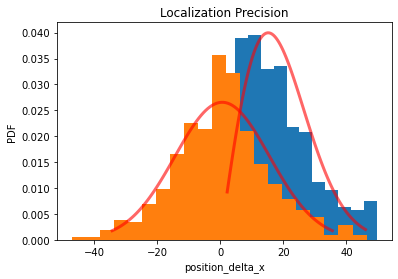

In [9]:
pipe.lp.hist();
print(pipe.lp.distribution_statistics.parameter_dict())
pipe.lp.hist(loc_property='position_delta_x');
print(pipe.lp.distribution_statistics.parameter_dict())

You can recover the computation procedure:

In [10]:
pipe.computation_as_string()

'def computation(self, locdata, n_localizations_min=4):\n    \n    # import required modules\n    from locan.analysis import LocalizationPrecision\n    \n    # prologue\n    self.file_indicator = locdata.meta.file_path\n    self.locdata = locdata\n    \n    # check requirements\n    if len(locdata)<=n_localizations_min:\n        return None\n    \n    # compute localization precision\n    self.lp = LocalizationPrecision().compute(self.locdata)\n    \n    return self\n'

or save it as text protocol:

The Pipeline object is pickleable and can thus be saved for revisits.

## Apply the pipeline on multiple datasets - a batch process

Let's create multiple datasets:

In [11]:
path = sp.ROOT_DIR / 'tests/Test_data/rapidSTORM_dstorm_data.txt'
print(path)
dat = sp.load_rapidSTORM_file(path=path)

locdatas = [sp.select_by_condition(dat, f'{min}<index<{max}') for min, max in ((0,300), (301,600), (601,900))]
locdatas

c:\users\soeren\mydata\programming\python\projects\locan\locan\tests\Test_data\rapidSTORM_dstorm_data.txt


Run the analysis pipeline as batch process

In [12]:
pipes = [sp.Pipeline(computation=computation, locdata=dat).compute() for dat in locdatas]

Processed frames:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.40it/s]


As long as the batch procedure runs in a single computer process, the identifier increases with every instantiation.

In [13]:
[pipe.meta.identifier for pipe in pipes]

['2', '3', '4']

### Visualize the combined results

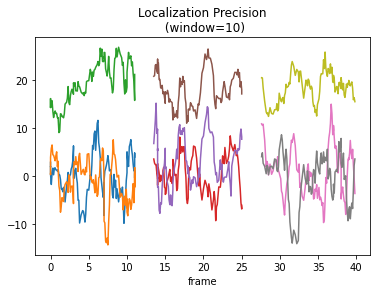

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for pipe in pipes:
    pipe.lp.plot(ax=ax, window=10)
plt.show()